BTC_price_at_start_time:  29844.99
start_time_code:  2023-07-18 16:29:32.782621


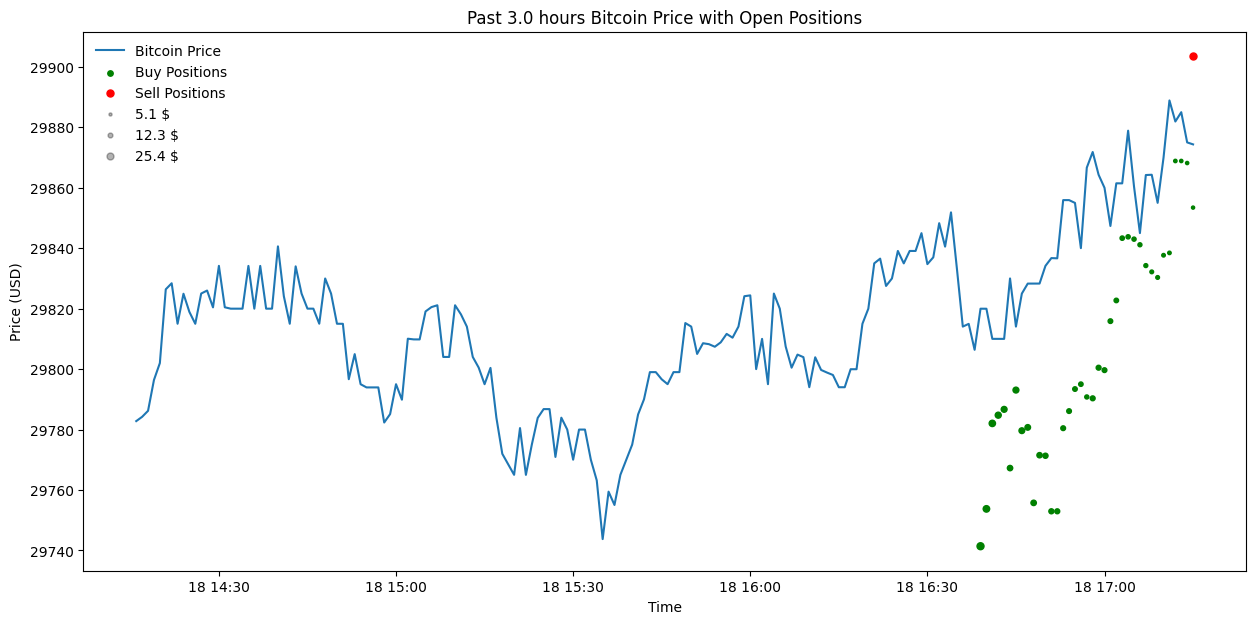

Number of open positions:  38
Number of buy positions:  37
Number of sell positions:  1
Total USDT value of open positions: $ -417.295
Total VaR of open positions: $ 1.245
Total Inventory Balance: $453.1893194861
--------------------------------------------------
Total account value (current BTC price & current BTC & current USDT): $ 1051.54
Ref. in Bull Market: Total (Adjusted) account value (start_time BTC price & current BTC & current USDT): $ 1051.41
Ref. in Bear Market: Initial account balance (start_time BTC price & start_time BTC & start_time USDT): $ 1051.29
Profit: $ 0.12
--------------------------------------------------



In [62]:
import csv
import matplotlib.pyplot as plt
import ccxt
import urllib.parse
import hashlib
import hmac
import base64
import requests
import time
import csv
import json
import time
import pandas as pd
import numpy as np 
import datetime
import urllib.parse
import hashlib
import hmac
import base64
import requests
import time
import csv
import json
# personal modules
from Get_balance import get_total_btc, get_total_usdt
from realtime_price_BTCUSDT_call import get_BTCUSDT_realtime_price
from counter_num_open_positions import count_num_open_positions

# Read BTC price, BTC balance, and USDT price at start time from the csv file
with open('BTC_price_n_Account_Balance_n_start_time.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Skip the header
    for row in reader:
        BTC_price_at_start_time = float(row[0])
        BTC_balance_at_start_time = float(row[1])
        USDT_balance_at_start_time = float(row[2])
print('BTC_price_at_start_time: ', BTC_price_at_start_time)
# print('BTC_balance_at_start_time: ', BTC_balance_at_start_time)
# print('USDT_balance_at_start_time: ', USDT_balance_at_start_time)

# Read the start time from the csv file
with open('start_time.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        start_time_code = row[0]
print('start_time_code: ', start_time_code)

#######################################################
# Binance US API initialization
#######################################################

api_key = 'LD5eq9nHMz51lvNxA4Yk4Npm02kS09oZU7tdvvkQKpcmLhdoCmUPKEv9xebfHavB'
secret_key = 'DtWIdtZRbtBDzzZPFVVgH39nr3VTNhz7njsb3HHGrYoHJcVl5fB1Jpdc5HoJJTfo'
api_url = "https://api.binance.us"

# get binanceus signature
def get_binanceus_signature(data, secret):
    postdata = urllib.parse.urlencode(data)
    message = postdata.encode()
    byte_key = bytes(secret, 'UTF-8')
    mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
    return mac

# Attaches auth headers and returns results of a POST request
def binanceus_request(uri_path, data, api_key, api_sec):
    headers = {}
    headers['X-MBX-APIKEY'] = api_key
    signature = get_binanceus_signature(data, api_sec)
    params={
        **data,
        "signature": signature,
        }
    req = requests.get((api_url + uri_path), params=params, headers=headers)
    return req.text

#######################################################
# Get all of the open positions
#######################################################

X_minutes = 180 # plot past X minutes of data

uri_path = "/api/v3/openOrders"
data = {
    "timestamp": int(round(time.time() * 1000))
}

result = binanceus_request(uri_path, data, api_key, secret_key)
result = json.loads(result)

# Open the file in write mode ('w') and create a CSV writer
with open('open_positions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # Write a header row
    writer.writerow(['Quantity', 'Price', 'Side'])

    # Iterate over the result and write each open position to the file
    for open_position in result:
        quantity = open_position['origQty']
        price = open_position['price']
        side = open_position['side']
        writer.writerow([quantity, price, side])

#######################################################
# Plotting
#######################################################

# Initialize the ccxt exchange
exchange = ccxt.binanceus()
symbol = 'BTC/USDT'
# Fetch past 60 minutes of data
bars = exchange.fetch_ohlcv(symbol, '1m', limit=X_minutes)
# Get closing prices and timestamps
prices = [bar[4] for bar in bars]
timestamps = [bar[0] for bar in bars]
# Convert timestamps to datetime and remove the seconds for cleaner plotting
dates = [datetime.datetime.fromtimestamp(timestamp/1000).replace(second=0, microsecond=0) for timestamp in timestamps]
# Read open positions from file
with open('open_positions.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    open_positions = list(reader)

# Add the order value to the open_positions list
for open_position in open_positions:
    quantity = float(open_position[0])
    price = float(open_position[1])
    open_position.append(quantity * price)

# Separate buy and sell positions
buy_positions = [[float(pos[1]), pos[3]] for pos in open_positions if pos[2] == 'BUY']
sell_positions = [[float(pos[1]), pos[3]] for pos in open_positions if pos[2] == 'SELL']

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(15, 7))

# Plot the data
ax.plot(dates, prices, label='Bitcoin Price')
if buy_positions:
    buy_prices, buy_sizes = zip(*buy_positions)
    ax.scatter(dates[-len(buy_positions):], buy_prices, s=buy_sizes, color='g', label='Buy Positions')
if sell_positions:
    sell_prices, sell_sizes = zip(*sell_positions)
    ax.scatter(dates[-len(sell_positions):], sell_prices, s=sell_sizes, color='r', label='Sell Positions')

# Define some representative sizes for the legend
sizes = [np.min(buy_sizes+sell_sizes), np.mean(buy_sizes+sell_sizes), np.max(buy_sizes+sell_sizes)]

# Create a scatter plot for each representative size
for size in sizes:
    ax.scatter([], [], c='k', alpha=0.3, s=size, label="{:.1f} $".format(size))


ax.set_title("Past "+str(X_minutes/60)+" hours Bitcoin Price with Open Positions")
ax.set_xlabel("Time")
ax.set_ylabel("Price (USD)")
ax.legend(scatterpoints=1, frameon=False, labelspacing=0.5, loc='upper left')
plt.show()

#######################################################
# Risk-Reward Analysis | Portfolio Management
#######################################################

print("Number of open positions: ", len(open_positions))
num_open_positions = len(open_positions)
print("Number of buy positions: ", len(buy_positions))
print("Number of sell positions: ", len(sell_positions))
last_price = prices[-1]

# calculate risk of open positions (quantity * delta_price)
total_usdt_value = 0
total_btc_value = 0
for open_position in open_positions:
    if open_position[2] == "BUY":
        total_usdt_value -= abs((float(open_position[1])) * float(open_position[0]))
        total_btc_value += abs (float(open_position[0]))
    elif open_position[2] == "SELL":
        total_usdt_value += abs((float(open_position[1])) * float(open_position[0]))
        total_btc_value -= abs (float(open_position[0]))

print("Total USDT value of open positions: $", round(total_usdt_value , 4))

# calculate total at risk value of open positions
total_at_risk_value = 0
price_at_the_moment = float(prices[-1])
for open_position in open_positions:
    if open_position[2] == "BUY":
        total_at_risk_value += abs(float(price_at_the_moment-float(open_position[1]))) * float(open_position[0])
    elif open_position[2] == "SELL":
        total_at_risk_value += abs(float(price_at_the_moment-float(open_position[1]))) * float(open_position[0])
print("Total VaR of open positions: $", round(total_at_risk_value, 4))
total_reward = abs((total_btc_value * float(prices[-1]))+total_usdt_value)
# print("Total reward (i.e. if all open positions closed): $", total_reward)
# sharpe_ratio = total_reward / total_at_risk_value
# print("Sharpe ratio (at the moment): ", sharpe_ratio)
main_account_balance_df = pd.read_csv('Deployed_main_account_balance.csv')
print("Total Inventory Balance: $" + str(main_account_balance_df.iloc[-1, 0]))
print('--------------------------------------------------')
moment_price = float(prices[-1])
total_btc_at_the_moment = get_total_btc()
total_usdt_at_the_moment = get_total_usdt()
total_account_value = total_btc_at_the_moment * moment_price + total_usdt_at_the_moment
print("Total account value (current BTC price & current BTC & current USDT): $", round((total_account_value),2))
# total account value with start time BTC price
total_account_value_with_start_BTC_price_n_current_USDT = BTC_price_at_start_time * total_btc_at_the_moment + total_usdt_at_the_moment
print('Ref. in Bull Market: Total (Adjusted) account value (start_time BTC price & current BTC & current USDT): $', round((total_account_value_with_start_BTC_price_n_current_USDT), 2))
# print('Profit: $', round((total_account_value_with_start_BTC_price_n_current_USDT - total_account_value), 2))
initial_account_balance = BTC_price_at_start_time * BTC_balance_at_start_time + USDT_balance_at_start_time
print('Ref. in Bear Market: Initial account balance (start_time BTC price & start_time BTC & start_time USDT): $', round(initial_account_balance, 2))
print('Profit: $', round(min((total_account_value - initial_account_balance), (total_account_value - total_account_value_with_start_BTC_price_n_current_USDT)), 2))
print('--------------------------------------------------')
print()

In [63]:
import requests
import urllib.parse
import hashlib
import hmac
import time
import csv
import os
import json
import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import pytz

# initialize
if True:
    # Read BTC price, BTC balance, and USDT price at start time from the csv file
    with open('BTC_price_n_Account_Balance_n_start_time.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip the header

        for i, row in enumerate(reader, start=1):  # enumerate() provides a simple 'counter' that starts at 1
            if i == 3:
                BTC_price_at_start_time = float(row[0])
                BTC_balance_at_start_time = float(row[1])
                USDT_balance_at_start_time = float(row[2])
                start_time_code = row[3]
                break  # Exit the loop after the third row

    print(f"BTC Price at Start Time: ${BTC_price_at_start_time}")
    print(f"BTC Balance at Start Time: {BTC_balance_at_start_time}")
    print(f"USDT Balance at Start Time: ${USDT_balance_at_start_time}")
    initial_account_balance = BTC_price_at_start_time * BTC_balance_at_start_time + USDT_balance_at_start_time
    print(f"Initial Balance: ${initial_account_balance}")
    print(f"Start Time: {start_time_code}")
    print('----------------------------------------')

    # start_time_code = "2023-07-15 11:00:00.479540"

    # Convert it to a datetime object
    start_time_code_dt = datetime.datetime.strptime(start_time_code, "%Y-%m-%d %H:%M:%S.%f")
    # print("start_time_code_dt: ", start_time_code_dt)

    # Convert to timestamp and use as start_time
    start_time_code_ts = int(start_time_code_dt.timestamp() * 1000)
    # print("start_time_code: ", start_time_code_ts)

    # Convert start_time_code_dt to a timezone-aware datetime object in UTC
    pacific = pytz.timezone('US/Pacific')
    start_time_code_dt = pacific.localize(start_time_code_dt)
    start_time_code_dt = start_time_code_dt.astimezone(pytz.UTC)

    # Convert to a timestamp (in milliseconds)
    start_time = int(start_time_code_dt.timestamp() * 1000)
    end_time = start_time + 24*60*60*1000 # plus 24 hours in milliseconds

    api_key = 'LD5eq9nHMz51lvNxA4Yk4Npm02kS09oZU7tdvvkQKpcmLhdoCmUPKEv9xebfHavB'
    secret_key = 'DtWIdtZRbtBDzzZPFVVgH39nr3VTNhz7njsb3HHGrYoHJcVl5fB1Jpdc5HoJJTfo'
    api_url = "https://api.binance.us"
    uri_path = "/api/v3/allOrders"

    symbol = 'BTCUSDT'
    limit = 1000

    data = {
        "timestamp": int(round(time.time() * 1000)),
        "symbol": "BTCUSD"
    }

    # get binanceus signature
    def get_binanceus_signature(data, secret):
        postdata = urllib.parse.urlencode(data)
        message = postdata.encode()
        byte_key = bytes(secret, 'UTF-8')
        mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
        return mac

    # Attaches auth headers and returns results of a POST request
    def binanceus_request(uri_path, data, api_key, api_sec):
        headers = {}
        headers['X-MBX-APIKEY'] = api_key
        signature = get_binanceus_signature(data, api_sec)
        params={
            **data,
            "signature": signature,
            }
        req = requests.get((api_url + uri_path), params=params, headers=headers)
        return req.text

# get all orders
if True:
    #############################################
    # Get all orders
    #############################################

    # Create a DataFrame to hold all data
    all_data = pd.DataFrame()

    while True:
        data = {
            'symbol': symbol,
            'timestamp': int(round(time.time() * 1000)),
            'limit': limit,
            'startTime': start_time,
            'endTime': end_time
        }

        # print('Fetching orders from', datetime.datetime.fromtimestamp(start_time/1000), 'to', datetime.datetime.fromtimestamp(end_time/1000))

        result = binanceus_request(uri_path, data, api_key, secret_key)
        data = json.loads(result)

        if not isinstance(data, list):
            print('Unexpected response:', data)
            break

        if not data:  # If data is empty, we've fetched all the orders
            break

        # Append new data to all_data DataFrame
        data_df = pd.DataFrame(data)
        all_data = pd.concat([all_data, data_df])

        # Update start_time and end_time for the next request
        start_time = data[-1]['time'] + 1
        end_time = min(int(datetime.datetime.now().timestamp() * 1000), start_time + 24*60*60*1000)  # plus 24 hours or current time whichever is smaller
        
    all_data = all_data[all_data['time'] > start_time_code_ts]
    all_data.to_csv('All_Orders_ThisRun.csv', index=False)

# plot
if True:
        #############################################
        # plot the data
        #############################################

        # Load the new data
        df_new = pd.read_csv('All_Orders_ThisRun.csv')

        # Calculate price per unit
        df_new['price_per_unit'] = df_new['price']
        df_new.loc[df_new['price'] == 0, 'price_per_unit'] = df_new['cummulativeQuoteQty'] / df_new['executedQty']

        # Separate buy and sell orders
        df_buy_new = df_new[df_new['side'] == 'BUY']
        df_sell_new = df_new[df_new['side'] == 'SELL']

        # Sort by time
        df_buy_new = df_buy_new.sort_values('time')
        df_sell_new = df_sell_new.sort_values('time')

        # Convert 'time' to datetime and set as index
        df_buy_new['time'] = pd.to_datetime(df_buy_new['time'], unit='ms')
        df_sell_new['time'] = pd.to_datetime(df_sell_new['time'], unit='ms')

        # Localize to UTC and then convert to PST
        df_buy_new['time'] = df_buy_new['time'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
        df_sell_new['time'] = df_sell_new['time'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

        df_buy_new.set_index('time', inplace=True)
        df_sell_new.set_index('time', inplace=True)

        # Plotting 

        # plt.figure(figsize=(15, 7))
        # plt.plot(df_buy_new.index, df_buy_new['price_per_unit'], 'go', markersize=5, label='Buy')
        # plt.plot(df_sell_new.index, df_sell_new['price_per_unit'], 'ro', markersize=5, label='Sell')
        # plt.title('ALL ORDERS (This Run)')
        # plt.xlabel('Time')
        # plt.ylabel('Price per Unit')
        # plt.legend()
        # plt.grid(True)
        # plt.show()

#############################################
# calculate the profit
#############################################
total_num_of_orders = df_new.shape[0]
print('Total number of orders: ', total_num_of_orders)
canceled_num_of_orders = df_new[df_new['status'] == 'CANCELED'].shape[0]
print("Number of orders that were canceled: ", canceled_num_of_orders)
expired_in_match_num_of_orders = df_new[df_new['status'] == 'EXPIRED_IN_MATCH'].shape[0]
print("Number of orders that were expired in match: ", expired_in_match_num_of_orders)
partially_filled_num_of_orders = df_new[df_new['status'] == 'PARTIALLY_FILLED'].shape[0]
print('Number of orders that were partially filled: ', partially_filled_num_of_orders)
open_num_of_orders = df_new[df_new['status'] == 'NEW'].shape[0]
print('Number of orders that are still open: ', open_num_of_orders)
Accuracy_including_Canceled_Expired_PartiallyFilled = 1 - (df_new[df_new['status'] == 'EXPIRED_IN_MATCH'].shape[0] + df_new[df_new['status'] == 'CANCELED'].shape[0] + df_new[df_new['status'] == 'PARTIALLY_FILLED'].shape[0]) / (df_new.shape[0] / 2)
print('Accuracy:', round(Accuracy_including_Canceled_Expired_PartiallyFilled, 2))
print('-----------------------------------------')

## calculated lost profit from expired orders ##

# Find the indices of 'EXPIRED_IN_MATCH' orders
expired_in_match_indices = df_new.index[df_new['status'] == 'EXPIRED_IN_MATCH'].tolist()
# Since every 'EXPIRED_IN_MATCH' order is the second in a pair, the pair order would be at the index before it.
pair_indices = [index - 1 for index in expired_in_match_indices]
# Split the 'EXPIRED_IN_MATCH' orders and their pair orders into separate DataFrames
expired_orders_df = df_new.loc[expired_in_match_indices]
pair_orders_df = df_new.loc[pair_indices]
# Reset the indices of both dataframes
pair_orders_df = pair_orders_df.reset_index(drop=True)
expired_orders_df = expired_orders_df.reset_index(drop=True)
# Calculate the absolute difference between the cost of each executed market order and the potential revenue from each expired limit order
abs_differences_expired_orders = abs((pair_orders_df['origQty'] * pair_orders_df['price_per_unit']) - (expired_orders_df['origQty'] * expired_orders_df['price_per_unit']))
# The lost profit is the sum of these absolute differences
lost_profit_expired_orders = abs_differences_expired_orders.sum()
# print('The lost profit from EXPIRED_IN_MATCH orders and their pair orders is: ', lost_profit_expired_orders)

## calculated lost profit from cancelled orders ##

# Find the indices of 'CANCELED' orders
canceled_indices = df_new.index[df_new['status'] == 'CANCELED'].tolist()
# Since every 'CANCELED' order is the second in a pair, the pair order would be at the index before it.
pair_indices_canceled_orders = [index - 1 for index in canceled_indices]
# Split the 'CANCELED' orders and their pair orders into separate DataFrames
canceled_orders_df = df_new.loc[canceled_indices]
pair_orders_canceled_df = df_new.loc[pair_indices_canceled_orders]
# Reset the indices of both dataframes
pair_orders_canceled_df = pair_orders_canceled_df.reset_index(drop=True)
canceled_orders_df = canceled_orders_df.reset_index(drop=True)
# Calculate the absolute difference between the cost of each executed market order and the potential revenue from each cancelled limit order
abs_differences_canceled_orders = abs((pair_orders_canceled_df['origQty'] * pair_orders_canceled_df['price_per_unit']) - (canceled_orders_df['origQty'] * canceled_orders_df['price_per_unit']))
# The lost profit is the sum of these absolute differences
lost_profit_canceled_orders = abs_differences_canceled_orders.sum()
# print('The lost profit from CANCELED orders and their pair orders is: ', lost_profit_canceled_orders)

## calculated lost profit from canceling open-orders ##

# Find the indices of 'NEW' orders
new_order_indices = df_new.index[df_new['status'] == 'NEW'].tolist()
# Since every 'NEW' order is the second in a pair, the pair order would be at the index before it.
pair_indices_new_orders = [index - 1 for index in new_order_indices]
# Split the 'NEW' orders and their pair orders into separate DataFrames
new_orders_df = df_new.loc[new_order_indices]
pair_orders_new_df = df_new.loc[pair_indices_new_orders]
# Reset the indices of both dataframes
pair_orders_new_df = pair_orders_new_df.reset_index(drop=True)
new_orders_df = new_orders_df.reset_index(drop=True)
# Calculate the absolute difference between the cost of each executed market order and the potential revenue from each new limit order
abs_differences_new_orders = abs((pair_orders_new_df['origQty'] * pair_orders_new_df['price_per_unit']) - (new_orders_df['origQty'] * new_orders_df['price_per_unit']))
# The lost profit is the sum of these absolute differences
lost_profit_new_orders = abs_differences_new_orders.sum()
# print('The potential lost profit from NEW orders and their pair orders is: ', lost_profit_new_orders)

## remove EXPIRED_IN_MATCH orders and their pair orders from the DataFrame ##

# Filter 'EXPIRED_IN_MATCH' orders and their pair
expired_in_match_indices = df_new.index[df_new['status'] == 'EXPIRED_IN_MATCH'].tolist()
# the pair order would be at the index before it. We also need to remove these indices.
pair_indices = [index - 1 for index in expired_in_match_indices]
# Combine both lists of indices
all_indices_to_remove = expired_in_match_indices + pair_indices
# Select these indices and save to a new DataFrame
df_expired_orders = df_new.loc[all_indices_to_remove]
# Save these orders in a separate CSV file
df_expired_orders.to_csv('expired_orders.csv', index=False)
# Drop these indices from the DataFrame
df_clean = df_new.drop(all_indices_to_remove)
df_new = df_clean

## remove CANCLED orders and their pair orders from the DataFrame ##

# Filter 'CANCELED' orders and their pair
canceled_indices = df_new.index[df_new['status'] == 'CANCELED'].tolist()
# the pair order would be at the index before it. We also need to remove these indices.
canceled_pair_indices = [index - 1 for index in canceled_indices]
# Combine both lists of indices
canceled_all_indices_to_remove = canceled_indices + canceled_pair_indices
# Select these indices and save to a new DataFrame
df_canceled_orders = df_new.loc[canceled_all_indices_to_remove]
# Save these orders in a separate CSV file
df_canceled_orders.to_csv('canceled_orders.csv', index=False)
# Drop these indices from the DataFrame
df_clean = df_new.drop(canceled_all_indices_to_remove)
df_new = df_clean

## remove PARTIALLY_FILLED orders and their pair orders from the DataFrame ##

# Filter 'PARTIALLY_FILLED' orders and their pair
partially_filled_indices = df_new.index[df_new['status'] == 'PARTIALLY_FILLED'].tolist()
# the pair order would be at the index before it. We also need to remove these indices.
partially_filled_pair_indices = [index - 1 for index in partially_filled_indices]
# Combine both lists of indices
partially_filled_all_indices_to_remove = partially_filled_indices + partially_filled_pair_indices
# Select these indices and save to a new DataFrame
df_partially_filled_orders = df_new.loc[partially_filled_all_indices_to_remove]
# Save these orders in a separate CSV file
df_partially_filled_orders.to_csv('partially_filled_orders.csv', index=False)
# Drop these indices from the DataFrame
df_clean = df_new.drop(partially_filled_all_indices_to_remove)
df_new = df_clean

## remove NEW orders (open-orders) and their pair orders from the DataFrame ##

# Filter 'NEW' orders and their pair
new_indices = df_new.index[df_new['status'] == 'NEW'].tolist()
# the pair order would be at the index before it. We also need to remove these indices.
new_pair_indices = [index - 1 for index in new_indices]
# Combine both lists of indices
new_all_indices_to_remove = new_indices + new_pair_indices
# Select these indices and save to a new DataFrame
df_new_orders = df_new.loc[new_all_indices_to_remove]
# Save these orders in a separate CSV file
df_new_orders.to_csv('new_orders.csv', index=False)
# Drop these indices from the DataFrame
df_clean = df_new.drop(new_all_indices_to_remove)
df_new = df_clean
print('The number of new orders: ', len(df_new_orders))

# Save Filled orders in a separate CSV file
df_filled_orders = df_new[df_new['status'] == 'FILLED']
df_filled_orders.to_csv('filled_orders.csv', index=False)
print('The number of filled orders: ', len(df_filled_orders))

## calculated profit from filled orders ##

# Create a new dataframe that contains only 'FILLED' orders and their pair orders
filled_orders_df = df_filled_orders[df_filled_orders['status'] == 'FILLED'].copy()
# Add a new column 'pair_price_per_unit' that contains the 'price_per_unit' of the pair order
filled_orders_df['pair_price_per_unit'] = filled_orders_df['price_per_unit'].shift(1)
# Calculate the profit from each pair
filled_orders_df['profit'] = abs(filled_orders_df['pair_price_per_unit'] - filled_orders_df['price_per_unit']) * filled_orders_df['origQty']
# The total profit is the sum of the profits from each pair
total_profit = filled_orders_df['profit'].sum()
print('## Total profit from filled orders is: ', round(total_profit, 4))

# calculate profit
if True:
    net_profit = total_profit - lost_profit_expired_orders - lost_profit_new_orders - lost_profit_canceled_orders
    avg_profit_per_minute = net_profit / (total_num_of_orders//2)
    average_profit_per_minute_percent = avg_profit_per_minute / initial_account_balance * 100 
    avg_profit_per_day = (avg_profit_per_minute)*1440
    avg_profit_per_day_percent = avg_profit_per_day / initial_account_balance * 100 
    
#print result
if True:
    print("----------------------------------------")
    print('lost profit of open orders (if canceled):$', round(lost_profit_new_orders, 4))
    print('lost profit of expired orders:$', round(lost_profit_expired_orders, 4))
    print('lost profit of canceled orders:$', round(lost_profit_canceled_orders, 4))
    print("** Total Profit:$",  round(total_profit, 4))
    print('** Net Profit:$', round(net_profit, 4))  
    print("----------------------------------------")
    print('Average Net Profit per Minute:$', round(avg_profit_per_minute, 4))
    print('Average Net Profit per Minute (% of initial account balance):', round(average_profit_per_minute_percent, 4))
    print('Average Net Profit per Day:$', round(avg_profit_per_day, 4))
    print('Average Net Profit per Day (% of initial account balance):', round(avg_profit_per_day_percent, 4))
    print('Average Net Profit per Month (% of initial account balance):', round(((100+avg_profit_per_day_percent)/100)**30*100-100, 4))
    print('Average Net Profit per Year (% of initial account balance):', round(((100+avg_profit_per_day_percent)/100)**365*100-100, 4))

BTC Price at Start Time: $30234.99
BTC Balance at Start Time: 0.02088933
USDT Balance at Start Time: $429.71675688
Initial Balance: $1061.3054405367
Start Time: 2023-07-16 17:02:25.422299
----------------------------------------
Total number of orders:  5731
Number of orders that were canceled:  291
Number of orders that were expired in match:  192
Number of orders that were partially filled:  0
Number of orders that are still open:  43
Accuracy: 0.83
-----------------------------------------
The number of new orders:  86
The number of filled orders:  4679
## Total profit from filled orders is:  29.7224
----------------------------------------
lost profit of open orders (if canceled):$ 0.2875
lost profit of expired orders:$ 0.7845
lost profit of canceled orders:$ 3.6512
** Total Profit:$ 29.7224
** Net Profit:$ 24.9993
----------------------------------------
Average Net Profit per Minute:$ 0.0087
Average Net Profit per Minute (% of initial account balance): 0.0008
Average Net Profit p

In [929]:
profit_moment = 0
profit_list = []

start_time_code: 2023-07-17 03:18:50.255811


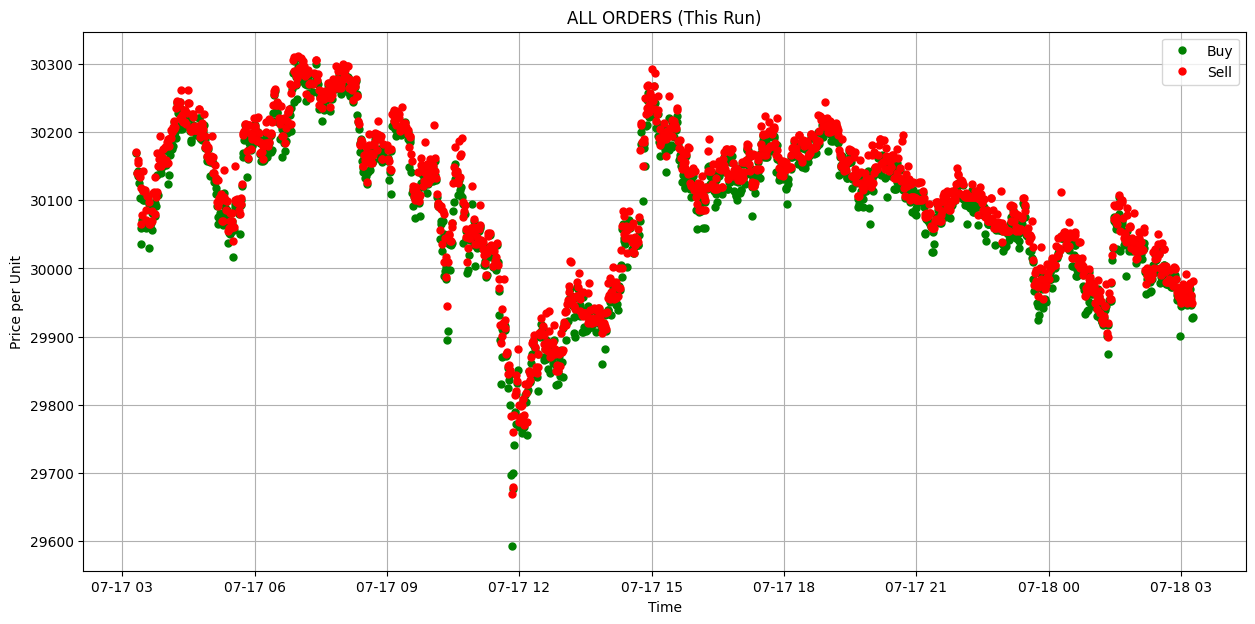

Number of orders that were expired in match:  84
Number of orders that were cancelled:  136
Number of orders that were partially filled:  0
-----------------------------------------
Accuracy (only cancelled orders): 0.9
including expired in match and partially filled orders:
Accuracy: 0.85
Total Orders: 2346
(excluding EXPIRED_IN_MATCH, CANCELLED, and PARTIALLY_FILLED orders and their pairs)
Total Buy Orders: 1173
Total Sell Orders: 1173
----------------------------------------
Total Units Bought: 0.46852
Total Units Sold: 0.46835
Total Spent:$ 14101.7381
Total Earned:$ 14102.1085
Average Buy Price:$ 30098.4762
Average Sell Price:$ 30110.1921
----------------------------------------
Open Orders Buy Cost:$ 0.0
Open Orders Sell Revenue:$ 0.0
----------------------------------------
lost profit of open orders (if canceled):$ 0.3092
lost profit of expired orders:$ 0.354
lost profit of canceled orders:$ 1.7194
profit from filled orders:$ 2.3693
** Total Profit:$ 2.3693
** Net Profit:$ 0.295

In [1030]:
import requests
import urllib.parse
import hashlib
import hmac
import time
import csv
import os
import json
import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import pytz

# Read the start time from the csv file
with open('start_time.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        start_time_code = row[0]

start_time_code = "2023-07-17 03:18:50.255811"
print('start_time_code:', start_time_code)

# Convert it to a datetime object
start_time_code_dt = datetime.datetime.strptime(start_time_code, "%Y-%m-%d %H:%M:%S.%f")

# Convert to timestamp and use as start_time
start_time_code_ts = int(start_time_code_dt.timestamp() * 1000)

# Convert start_time_code_dt to a timezone-aware datetime object in UTC
pacific = pytz.timezone('US/Pacific')
start_time_code_dt = pacific.localize(start_time_code_dt)
start_time_code_dt = start_time_code_dt.astimezone(pytz.UTC)

# Convert to a timestamp (in milliseconds)
start_time = int(start_time_code_dt.timestamp() * 1000)
end_time = start_time + 24*60*60*1000 # plus 24 hours in milliseconds

api_key = 'LD5eq9nHMz51lvNxA4Yk4Npm02kS09oZU7tdvvkQKpcmLhdoCmUPKEv9xebfHavB'
secret_key = 'DtWIdtZRbtBDzzZPFVVgH39nr3VTNhz7njsb3HHGrYoHJcVl5fB1Jpdc5HoJJTfo'
api_url = "https://api.binance.us"
uri_path = "/api/v3/allOrders"

symbol = 'BTCUSDT'
limit = 1000

data = {
    "timestamp": int(round(time.time() * 1000)),
    "symbol": "BTCUSD"
}

# get binanceus signature
def get_binanceus_signature(data, secret):
    postdata = urllib.parse.urlencode(data)
    message = postdata.encode()
    byte_key = bytes(secret, 'UTF-8')
    mac = hmac.new(byte_key, message, hashlib.sha256).hexdigest()
    return mac

# Attaches auth headers and returns results of a POST request
def binanceus_request(uri_path, data, api_key, api_sec):
    headers = {}
    headers['X-MBX-APIKEY'] = api_key
    signature = get_binanceus_signature(data, api_sec)
    params={
        **data,
        "signature": signature,
        }
    req = requests.get((api_url + uri_path), params=params, headers=headers)
    return req.text

#############################################
# Get all orders
#############################################

# Create a DataFrame to hold all data
all_data = pd.DataFrame()

while True:
    data = {
        'symbol': symbol,
        'timestamp': int(round(time.time() * 1000)),
        'limit': limit,
        'startTime': start_time,
        'endTime': end_time
    }

    # print('Fetching orders from', datetime.datetime.fromtimestamp(start_time/1000), 'to', datetime.datetime.fromtimestamp(end_time/1000))

    result = binanceus_request(uri_path, data, api_key, secret_key)
    data = json.loads(result)

    if not isinstance(data, list):
        print('Unexpected response:', data)
        break

    if not data:  # If data is empty, we've fetched all the orders
        break

    # Append new data to all_data DataFrame
    data_df = pd.DataFrame(data)
    all_data = pd.concat([all_data, data_df])

    # Update start_time and end_time for the next request
    start_time = data[-1]['time'] + 1
    end_time = min(int(datetime.datetime.now().timestamp() * 1000), start_time + 24*60*60*1000)  # plus 24 hours or current time whichever is smaller

all_data = all_data[all_data['time'] > start_time_code_ts]
all_data.to_csv('All_Orders_ThisRun.csv', index=False)

#############################################
# plot the data
#############################################

# Load the new data
df_new = pd.read_csv('All_Orders_ThisRun.csv')

# Calculate price per unit
df_new['price_per_unit'] = df_new['price']
df_new.loc[df_new['price'] == 0, 'price_per_unit'] = df_new['cummulativeQuoteQty'] / df_new['executedQty']

# Separate buy and sell orders
df_buy_new = df_new[df_new['side'] == 'BUY']
df_sell_new = df_new[df_new['side'] == 'SELL']

# Sort by time
df_buy_new = df_buy_new.sort_values('time')
df_sell_new = df_sell_new.sort_values('time')


# Convert 'time' to datetime and set as index
df_buy_new['time'] = pd.to_datetime(df_buy_new['time'], unit='ms')
df_sell_new['time'] = pd.to_datetime(df_sell_new['time'], unit='ms')

# Localize to UTC and then convert to PST
df_buy_new['time'] = df_buy_new['time'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df_sell_new['time'] = df_sell_new['time'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

df_buy_new.set_index('time', inplace=True)
df_sell_new.set_index('time', inplace=True)

# Plotting 

plt.figure(figsize=(15, 7))
plt.plot(df_buy_new.index, df_buy_new['price_per_unit'], 'go', markersize=5, label='Buy')
plt.plot(df_sell_new.index, df_sell_new['price_per_unit'], 'ro', markersize=5, label='Sell')
plt.title('ALL ORDERS (This Run)')
plt.xlabel('Time')
plt.ylabel('Price per Unit')
plt.legend()
plt.grid(True)
plt.show()

#############################################
# calculate the profit
#############################################

print("Number of orders that were expired in match: ", df_new[df_new['status'] == 'EXPIRED_IN_MATCH'].shape[0])
print("Number of orders that were cancelled: ", df_new[df_new['status'] == 'CANCELED'].shape[0])
print('Number of orders that were partially filled: ', df_new[df_new['status'] == 'PARTIALLY_FILLED'].shape[0])
print('-----------------------------------------')
Accuracy_only_canceled_oreders = 1 - df_new[df_new['status'] == 'CANCELED'].shape[0] / df_new.shape[0] * 2
print('Accuracy (only cancelled orders):', round(Accuracy_only_canceled_oreders, 2))
Accuracy_including_Canceled_Expired_PartiallyFilled = 1 - (df_new[df_new['status'] == 'EXPIRED_IN_MATCH'].shape[0] + df_new[df_new['status'] == 'CANCELED'].shape[0] + df_new[df_new['status'] == 'PARTIALLY_FILLED'].shape[0]) / (df_new.shape[0] / 2)
print('including expired in match and partially filled orders:')
print('Accuracy:', round(Accuracy_including_Canceled_Expired_PartiallyFilled, 2))

## calculated lost profit from expired orders ##

# Find the indices of 'EXPIRED_IN_MATCH' orders
expired_in_match_indices = df_new.index[df_new['status'] == 'EXPIRED_IN_MATCH'].tolist()
# Since every 'EXPIRED_IN_MATCH' order is the second in a pair, the pair order would be at the index before it.
pair_indices = [index - 1 for index in expired_in_match_indices]
# Split the 'EXPIRED_IN_MATCH' orders and their pair orders into separate DataFrames
expired_orders_df = df_new.loc[expired_in_match_indices]
pair_orders_df = df_new.loc[pair_indices]
# Reset the indices of both dataframes
pair_orders_df = pair_orders_df.reset_index(drop=True)
expired_orders_df = expired_orders_df.reset_index(drop=True)
# Calculate the absolute difference between the cost of each executed market order and the potential revenue from each expired limit order
abs_differences_expired_orders = abs((pair_orders_df['origQty'] * pair_orders_df['price_per_unit']) - (expired_orders_df['origQty'] * expired_orders_df['price_per_unit']))
# The lost profit is the sum of these absolute differences
lost_profit_expired_orders = abs_differences_expired_orders.sum()
# print('The lost profit from EXPIRED_IN_MATCH orders and their pair orders is: ', lost_profit_expired_orders)

## calculated lost profit from cancelled orders ##

# Find the indices of 'CANCELED' orders
canceled_indices = df_new.index[df_new['status'] == 'CANCELED'].tolist()
# Since every 'CANCELED' order is the second in a pair, the pair order would be at the index before it.
pair_indices_canceled_orders = [index - 1 for index in canceled_indices]
# Split the 'CANCELED' orders and their pair orders into separate DataFrames
canceled_orders_df = df_new.loc[canceled_indices]
pair_orders_canceled_df = df_new.loc[pair_indices_canceled_orders]
# Reset the indices of both dataframes
pair_orders_canceled_df = pair_orders_canceled_df.reset_index(drop=True)
canceled_orders_df = canceled_orders_df.reset_index(drop=True)
# Calculate the absolute difference between the cost of each executed market order and the potential revenue from each cancelled limit order
abs_differences_canceled_orders = abs((pair_orders_canceled_df['origQty'] * pair_orders_canceled_df['price_per_unit']) - (canceled_orders_df['origQty'] * canceled_orders_df['price_per_unit']))
# The lost profit is the sum of these absolute differences
lost_profit_canceled_orders = abs_differences_canceled_orders.sum()
# print('The lost profit from CANCELED orders and their pair orders is: ', lost_profit_canceled_orders)


## calculated lost profit from cancelling open-orders ##

# Find the indices of 'NEW' orders
new_order_indices = df_new.index[df_new['status'] == 'NEW'].tolist()
# Since every 'NEW' order is the second in a pair, the pair order would be at the index before it.
pair_indices_new_orders = [index - 1 for index in new_order_indices]
# Split the 'NEW' orders and their pair orders into separate DataFrames
new_orders_df = df_new.loc[new_order_indices]
pair_orders_new_df = df_new.loc[pair_indices_new_orders]
# Reset the indices of both dataframes
pair_orders_new_df = pair_orders_new_df.reset_index(drop=True)
new_orders_df = new_orders_df.reset_index(drop=True)
# Calculate the absolute difference between the cost of each executed market order and the potential revenue from each new limit order
abs_differences_new_orders = abs((pair_orders_new_df['origQty'] * pair_orders_new_df['price_per_unit']) - (new_orders_df['origQty'] * new_orders_df['price_per_unit']))
# The lost profit is the sum of these absolute differences
lost_profit_new_orders = abs_differences_new_orders.sum()
# print('The potential lost profit from NEW orders and their pair orders is: ', lost_profit_new_orders)

## calculated profit from Filled orders ##

# Find the indices of 'FILLED' orders
filled_order_indices = df_new.index[df_new['status'] == 'FILLED'].tolist()
# Since every 'NEW' order is the second in a pair, the pair order would be at the index before it.
pair_indices_filled_orders = [index - 1 for index in filled_order_indices if index - 1 >= 0]
# Split the 'FILLED' orders and their pair orders into separate DataFrames
filled_orders_df = df_new.loc[filled_order_indices]
pair_orders_filled_df = df_new.loc[pair_indices_filled_orders]
# Reset the indices of both dataframes
pair_orders_filled_df = pair_orders_filled_df.reset_index(drop=True)
filled_orders_df = filled_orders_df.reset_index(drop=True)
# Calculate the absolute difference between the cost of each executed market order and the potential revenue from each new limit order
abs_differences_filled_orders = abs((pair_orders_filled_df['origQty'] * pair_orders_filled_df['price_per_unit']) - (filled_orders_df['origQty'] * filled_orders_df['price_per_unit']))
# The lost profit is the sum of these absolute differences
profit_filled_orders = abs_differences_filled_orders.sum()


## remove expired orders and their pair orders from the DataFrame ##

# Filter 'EXPIRED_IN_MATCH' orders and their pair
expired_in_match_indices = df_new.index[df_new['status'] == 'EXPIRED_IN_MATCH'].tolist()
# the pair order would be at the index before it. We also need to remove these indices.
pair_indices = [index - 1 for index in expired_in_match_indices]
# Combine both lists of indices
all_indices_to_remove = expired_in_match_indices + pair_indices
# Drop these indices from the DataFrame
df_clean = df_new.drop(all_indices_to_remove)
df_new = df_clean

## remove CANCLED orders and their pair orders from the DataFrame ##

# Filter 'EXPIRED_IN_MATCH' orders and their pair
canceled_indices = df_new.index[df_new['status'] == 'CANCELED'].tolist()
# the pair order would be at the index before it. We also need to remove these indices.
canceled_pair_indices = [index - 1 for index in canceled_indices]
# Combine both lists of indices
canceled_all_indices_to_remove = canceled_indices + canceled_pair_indices
# Drop these indices from the DataFrame
df_clean = df_new.drop(canceled_all_indices_to_remove)
df_new = df_clean
# df_new = df_new[df_new['status'] != 'CANCELED']

## remove PARTIALLY_FILLED orders and their pair orders from the DataFrame ##

# Filter 'EXPIRED_IN_MATCH' orders and their pair
partially_filled_indices = df_new.index[df_new['status'] == 'PARTIALLY_FILLED'].tolist()
# the pair order would be at the index before it. We also need to remove these indices.
partially_filled_pair_indices = [index - 1 for index in partially_filled_indices]
# Combine both lists of indices
partially_filled_all_indices_to_remove = partially_filled_indices + partially_filled_pair_indices
# Drop these indices from the DataFrame
df_clean = df_new.drop(partially_filled_all_indices_to_remove)
df_new = df_clean

## remove NEW orders and their pair orders from the DataFrame ##

# Filter 'NEW' orders and their pair
new_indices = df_new.index[df_new['status'] == 'NEW'].tolist()
# the pair order would be at the index before it. We also need to remove these indices.
new_pair_indices = [index - 1 for index in new_indices]
# Combine both lists of indices
new_all_indices_to_remove = new_indices + new_pair_indices
# Drop these indices from the DataFrame
df_clean = df_new.drop(new_all_indices_to_remove)
df_new = df_clean

# Separate buy and sell orders
df_buy_new = df_new[df_new['side'] == 'BUY']
df_sell_new = df_new[df_new['side'] == 'SELL']

# Create masks for the different conditions
is_partially_filled_or_new = df_new['status'].isin(['PARTIALLY_FILLED', 'NEW'])
is_sell = df_new['side'] == 'SELL'
is_buy = df_new['side'] == 'BUY'
# Use these masks to filter the dataframe and perform calculations
# Calculate open sell revenue
open_sell_mask = df_new[is_partially_filled_or_new & is_sell]
open_sell_revenue = (open_sell_mask['origQty'] * open_sell_mask['price']).sum()
# Calculate open buy cost
open_buy_mask = df_new[is_partially_filled_or_new & is_buy]
open_buy_cost = (open_buy_mask['origQty'] * open_buy_mask['price']).sum()

# calculate the total number of orders
total_orders = len(df_new)
total_buy_orders = len(df_buy_new)
total_sell_orders = len(df_sell_new)

# calculate the total number of units bought and sold
total_units_bought = df_new[(df_new['status'].isin(['FILLED'])) & (df_new['side'] == 'BUY')]['origQty'].sum()
total_units_sold = df_new[(df_new['status'].isin(['FILLED'])) & (df_new['side'] == 'SELL')]['origQty'].sum()

# calculate the total amount of money spent and earned
total_spent = df_buy_new['cummulativeQuoteQty'].sum() + open_buy_cost
total_earned = df_sell_new['cummulativeQuoteQty'].sum() + open_sell_revenue



# calculate the average price per unit bought and sold
avg_buy_price = total_spent / total_units_bought
avg_sell_price = total_earned / total_units_sold

# calculate the total profit
# total_profit = total_earned - total_spent
total_profit = profit_filled_orders

# calculate the average profit per unit
avg_profit_per_unit = avg_sell_price - avg_buy_price

# calculate the average profit per order
avg_profit_per_order = total_profit / total_orders

# calculate the average profit per minute (since you're placing an order every minute)
# initial_account_balance = 1065
initial_account_balance = BTC_price_at_start_time * BTC_balance_at_start_time + USDT_balance_at_start_time
avg_profit_per_minute = total_profit / (total_orders//2)
average_profit_per_minute_percent = avg_profit_per_minute / initial_account_balance * 100 # assuming $ 1088 initial account balance
avg_profit_per_minute_percent_of_spent_value = avg_profit_per_minute / total_spent * 100
# calculate the average profit per day
avg_profit_per_day = (avg_profit_per_minute)*1440
avg_profit_per_day_percent = avg_profit_per_day / initial_account_balance * 100 # assuming $ 1088 initial account balance
net_profit_from_start_of_run_till_now_v2 = total_profit - 0                   - lost_profit_expired_orders - lost_profit_canceled_orders

# print the results
print('Total Orders:', total_orders)
print('(excluding EXPIRED_IN_MATCH, CANCELLED, and PARTIALLY_FILLED orders and their pairs)')
print('Total Buy Orders:', total_buy_orders)
print('Total Sell Orders:', total_sell_orders)
print("----------------------------------------")
print('Total Units Bought:', round(total_units_bought, 10))
print('Total Units Sold:', round(total_units_sold, 10))
print('Total Spent:$', round(total_spent, 4))
print('Total Earned:$', round(total_earned, 4))
print('Average Buy Price:$', round(avg_buy_price, 4))
print('Average Sell Price:$', round(avg_sell_price, 4))
print("----------------------------------------")  
print('Open Orders Buy Cost:$', round(open_buy_cost, 4))
print('Open Orders Sell Revenue:$', round(open_sell_revenue, 4))
print("----------------------------------------")
print('lost profit of open orders (if canceled):$', round(lost_profit_new_orders, 4))
print('lost profit of expired orders:$', round(lost_profit_expired_orders, 4))
print('lost profit of canceled orders:$', round(lost_profit_canceled_orders, 4))
print('profit from filled orders:$', round(profit_filled_orders, 4))
print("** Total Profit:$",  round(total_profit, 4)) # assuming open-orders get closed
print('** Net Profit:$', round(net_profit_from_start_of_run_till_now_v2, 4))  
print("----------------------------------------")
print('Average Profit per Unit:$', round(avg_profit_per_unit, 4))
print('Average Profit per Order:$', round(avg_profit_per_order ,4))
print('Average Profit per Minute:$', round(avg_profit_per_minute, 4))
print('Average Profit per Minute (% of initial account balance):', round(average_profit_per_minute_percent, 4))
print('Average Profit per Minute (% of spent value):', round(avg_profit_per_minute_percent_of_spent_value, 4))
print('Average Profit per Day:$', round(avg_profit_per_day, 4))
print('Average Profit per Day (% of initial account balance):', round(avg_profit_per_day_percent, 4))
print('Average Profit per Month (% of initial account balance):', round(((100+avg_profit_per_day_percent)/100)**30*100-100, 4))
print('Average Profit per Year (% of initial account balance):', round(((100+avg_profit_per_day_percent)/100)**365*100-100, 4))